In [1]:
from ESP301Control import RotationStage
from TLBP2Control import TLBP2

import numpy as np
import matplotlib.pyplot as plt

from tinkerforge.ip_connection import IPConnection
from tinkerforge.bricklet_humidity import BrickletHumidity
from tinkerforge.bricklet_temperature import BrickletTemperature

from IPython.display import clear_output

from time import sleep

from Settings import *

In [7]:
HOST = 'localhost'
PORT = 4223

HUMIDITY_UID = 'keg'
TEMP_UID = '6Jf'

stage = RotationStage(MOTION_CONTROLLER_PORT, ROTATION_STAGE_AXIS_NUM)
bp2Device = TLBP2()
ipcon = IPConnection()

humiditySensor = BrickletHumidity(HUMIDITY_UID, ipcon)
temperatureSensor = BrickletTemperature(TEMP_UID, ipcon)

ipcon.connect(HOST, PORT)
stage.connect()
bp2Device.connect()

0

In [13]:
# Reset the rotation stage, and move to a good starting position
stage.resetToHome()

0

In [6]:
stage.moveAbsolute(30)

0

In [5]:
bp2Device.getMeasurement()

{'centroid': array([  -56.493958, -1054.1558  ]),
 'peak': array([ -113.42316, -1103.1638 ]),
 'peak_intensity': array([40.702847, 50.91437 ]),
 'drum_speed': 10.274588374303255,
 'beam_width': array([1434.4841 , 1005.48267]),
 'gaussian_fit_params_x': array([4.4604360e+03, 1.4209744e+03, 9.1887980e+03, 9.3540430e-01]),
 'gaussian_fit_params_y': array([3.3435793e+03, 9.8075710e+02, 1.2195989e+04, 9.5180040e-01])}

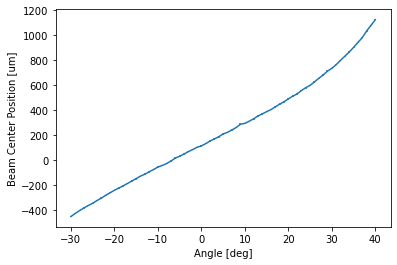

In [ ]:
stage.moveAbsolute(40)
desiredAngle = -40

dtheta = -1
averagingMeasurements = 20

peakPositionArr = []
centroidPosArr = []
gausCenterArr = []
temperatureArr = []
humidityArr = []
peakPositionSTDArr = []
centroidPosSTDArr = []
gausCenterSTDArr = []
angleArr = []

while stage.getAngle() > desiredAngle:
    peakIndividualMeasurements = np.zeros(averagingMeasurements)
    centroidIndividualMeasurements = np.zeros(averagingMeasurements)
    gausIndividualMeasurements = np.zeros(averagingMeasurements)
    
    for i in range(averagingMeasurements):
        measure = None
        while measure == None:
            measure = bp2Device.getMeasurement()
            
        peakIndividualMeasurements[i] = measure["peak"][0]
        centroidIndividualMeasurements[i] = measure["centroid"][0]
        gausIndividualMeasurements[i] = measure["gaussian_fit_params_x"][0]
        
    peakPositionArr.append(np.mean(peakIndividualMeasurements))
    peakPositionSTDArr.append(np.std(peakIndividualMeasurements))
    
    centroidPosArr.append(np.mean(centroidIndividualMeasurements))
    centroidPosSTDArr.append(np.std(centroidIndividualMeasurements))
    
    gausCenterArr.append(np.mean(gausIndividualMeasurements))
    gausCenterSTDArr.append(np.std(gausIndividualMeasurements))
    
    temperatureArr.append(temperatureSensor.get_temperature()/100)
    humidityArr.append(humiditySensor.get_humidity()/10)
    
    angleArr.append(stage.getAngle())

    clear_output(wait=True)

    plt.errorbar(angleArr, centroidPosArr, yerr=centroidPosSTDArr)
    plt.xlabel("Angle [deg]")
    plt.ylabel("Beam Center Position [um]")
    plt.show()
    
    # There tend to be some issues with the motion controller crashing
    # every now and again, so we can sorta account for that
    try:
        stage.moveRelative(dtheta)
    except:
        # If it crashes, we wait for it to reboot
        print("Motion controller crashed")
        raise Exception()

In [11]:
with open('data/sapphire_disk_852nm_2.txt', 'w') as outFile:
    outFile.write('angle,peak_position,peak_std,gauss_center,gauss_std,centroid,centroid_std,temp,humid')
    for i in range(len(angleArr)):
        outFile.write(f'\n{angleArr[i]},{peakPositionArr[i]},{peakPositionSTDArr[i]},{gausCenterArr[i]},{gausCenterSTDArr[i]},{centroidPosArr[i]},{centroidPosSTDArr[i]},{temperatureArr[i]},{humidityArr[i]}')

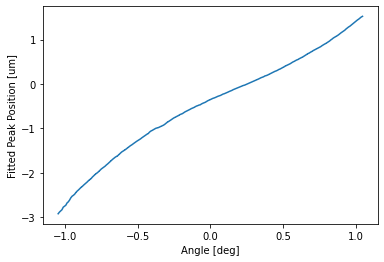

In [48]:
plt.errorbar(angleArr, peakPositionArr, yerr=np.array(peakPositionSTDArr)*1e-3)
plt.xlabel("Angle [deg]")
plt.ylabel("Fitted Peak Position [um]")
plt.savefig('initial_data.png')
plt.show()

In [33]:
nAir = 1.0
nGlass = 1.5 # Not really, but doesn't actually matter

# Fake cuvette size, just reasonable choices
d1 = 1e-1 # Width of cuvette wall [mm]
d2 = 1 # Width of cuvette cavity [mm]

def delta(theta, dtheta=0, offset=0, d1=d1, d2=d2, n0=nAir, n1=nGlass, n2=nAir):
    return offset + (2*d1*(1 - n0 * np.cos(theta+dtheta)/np.sqrt(n1**2 - n0**2 * np.sin(theta+dtheta)**2)) + d2*(1 - n0*np.cos(theta+dtheta)/np.sqrt(n2**2 - n0**2 * np.sin(theta+dtheta)**2))) * np.sin(theta+dtheta)

Calculated phase difference [-0.52359476  0.15793636]


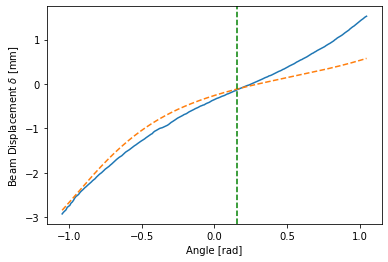

In [43]:
# Now recover the phase difference
from scipy.optimize import curve_fit

# Now fit our function with scipy
def wrap_func(th, phaseDiff, offset):
    return delta(th, dtheta=phaseDiff, offset=offset, d1=1.5 ,d2=8, n1=1.3)

#angleArr = -np.array(angleArr) * np.pi/180
#peakPositionArr = np.array(peakPositionArr) * 1e-3 - 4

#deltaArr = deltaArr + y_noise
popt, pcov = curve_fit(wrap_func, angleArr, peakPositionArr, bounds=(-np.pi/2 + .01, np.pi/2 + .01))

plt.plot(angleArr, peakPositionArr)
plt.plot(angleArr, wrap_func(angleArr, *popt), '--')
plt.axvline(popt[1], linestyle='--', color='g')
plt.xlabel('Angle [rad]')
plt.ylabel(r'Beam Displacement $\delta$ [mm]')

#print(f'Real phase difference: {phaseDiff}')
print(f'Calculated phase difference {popt}')
plt.savefig('initial_fit.png')
plt.show()

In [6]:
stage.disconnect()
bp2Device.disconnect()
ipcon.disconnect()

In [38]:
correctionAngle = popt[1] * 180 / np.pi
print(correctionAngle)
# Expectation: between 10-15 degrees

9.04908693958965


In [39]:
#stage.resetToHome()
#sleep(.5)
stage.moveAbsolute(-correctionAngle)

0